## **Bidirectional LSTM model using embedding layer**





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import time

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 22.4 MB/s eta 0:00:00


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### **Preprocessing** **Functions**

In [ ]:
def handle_negations(text):
    negation_patterns = ["n't", "not", "never", "no"]
    words = text.split()
    for i in range(len(words)):
        if words[i].lower() in negation_patterns:
            if i+1 < len(words):
                words[i+1] = "NOT_" + words[i+1]
    return ' '.join(words)

In [ ]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'@\w+', ' ', text)
        text = re.sub(r'#', ' ', text)
        text = re.sub(r'\w+:\/\/\S+', ' ', text)
        text = re.sub(r'\S*@\S*\s?', ' ', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'[^a-zA-Z]+', ' ', text)
        text = handle_negations(text)
        text = emoji.demojize(text)
        text = re.sub(r'\d+', ' ', text)
        text = text.lower()
    return text

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Sentiment_Data.csv', encoding='ISO-8859-1')
df.head()

Tweet Sentiment
0  @_angelica_toy Happy Anniversary!!!....The Day...  Mild_Pos
1  @McfarlaneGlenda Happy Anniversary!!!....The D...  Mild_Pos
2  @thevivafrei @JustinTrudeau Happy Anniversary!...  Mild_Pos
3  @NChartierET Happy Anniversary!!!....The Day t...  Mild_Pos
4  @tabithapeters05 Happy Anniversary!!!....The D...  Mild_Pos

In [ ]:
import seaborn as sns

In [ ]:
sentiment_map = {
    'Mild_Pos': 'Positive',
    'Strong_Pos': 'Positive',
    'Neutral': 'Neutral',
    'Strong_Neg': 'Negative',
    'Mild_Neg': 'Negative'
}
df['Sentiment'] = df['Sentiment'].map(sentiment_map)
df

Tweet Sentiment
0       @_angelica_toy Happy Anniversary!!!....The Day...  Positive
1       @McfarlaneGlenda Happy Anniversary!!!....The D...  Positive
2       @thevivafrei @JustinTrudeau Happy Anniversary!...  Positive
3       @NChartierET Happy Anniversary!!!....The Day t...  Positive
4       @tabithapeters05 Happy Anniversary!!!....The D...  Positive
...                                                   ...       ...
451327  Gaza; Peace n' Freedom - Viva Palestina convoy...  Positive
451328  Face of Defense: Soldier Finds Freedom in U.S....  Positive
451329  Face of Defense: Soldier Finds Freedom in U.S....  Positive
451330  Gaza; Peace n' Freedom - "Israel stops aid con...  Positive
451331             @convoy 83 yes! get on freedom server!  Positive

[451332 rows x 2 columns]

<ipython-input-9-94433cdbc716>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='viridis')


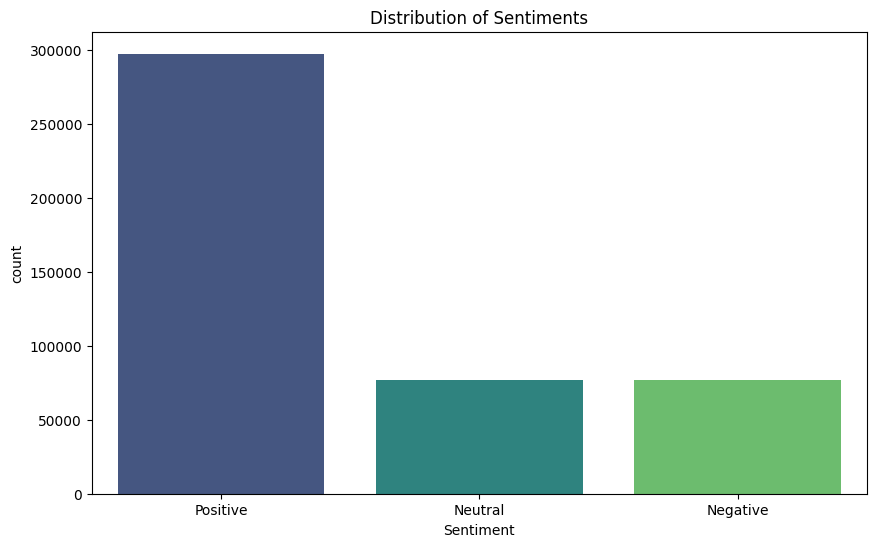

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiments')
plt.show()

In [ ]:
df['cleaned_Tweet'] = df['Tweet'].apply(clean_text)
df.head()

Tweet Sentiment  \
0  @_angelica_toy Happy Anniversary!!!....The Day...  Positive   
1  @McfarlaneGlenda Happy Anniversary!!!....The D...  Positive   
2  @thevivafrei @JustinTrudeau Happy Anniversary!...  Positive   
3  @NChartierET Happy Anniversary!!!....The Day t...  Positive   
4  @tabithapeters05 Happy Anniversary!!!....The D...  Positive   

                                       cleaned_Tweet  
0  happy anniversary the day the freedumb died in...  
1  happy anniversary the day the freedumb died in...  
2  happy anniversary the day the freedumb died in...  
3  happy anniversary the day the freedumb died in...  
4  happy anniversary the day the freedumb died in...

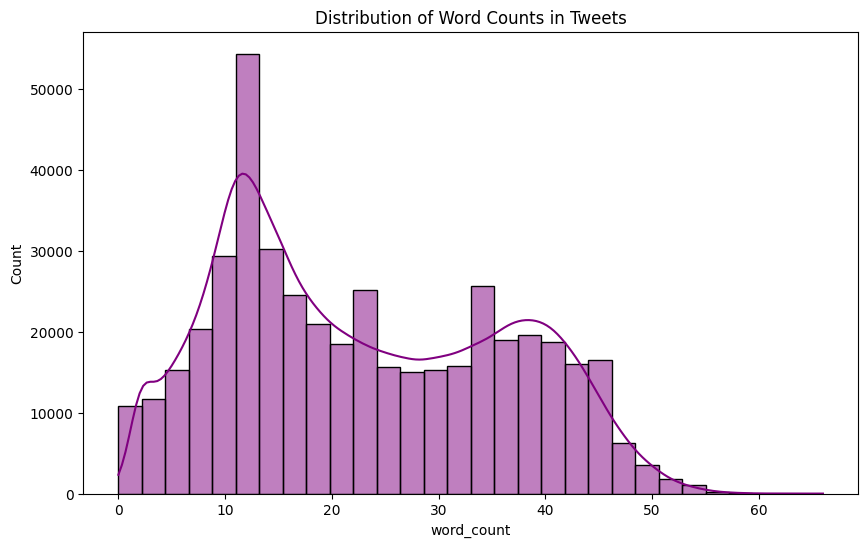

In [ ]:
df['word_count'] = df['cleaned_Tweet'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], kde=True, bins=30, color='purple')
plt.title('Distribution of Word Counts in Tweets')
plt.show()

### **Sampled Dataset**

In [ ]:
df = df.groupby('Sentiment').apply(lambda x: x.sample(n=76612, replace=True)).reset_index(drop=True)

In [ ]:
texts = df['cleaned_Tweet'].astype(str).values
labels = df['Sentiment'].values

### **Maping**

In [ ]:
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
labels = np.array([label_mapping[label] for label in labels])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
import nltk
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
tokenizer = Tokenizer(num_words=5000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(tweet):
    tokens = word_tokenize(tweet)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tweet = ' '.join(tokens)
    return tweet

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

X_train = [preprocess_text(tweet) for tweet in X_train]
X_test = [preprocess_text(tweet) for tweet in X_test]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Tokenizing**

In [ ]:
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

### **Uniform Input Size**

In [ ]:
X_train_pad = pad_sequences(X_train_seq, maxlen=30)
X_test_pad = pad_sequences(X_test_seq, maxlen=30)

### **PCA**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_pad)

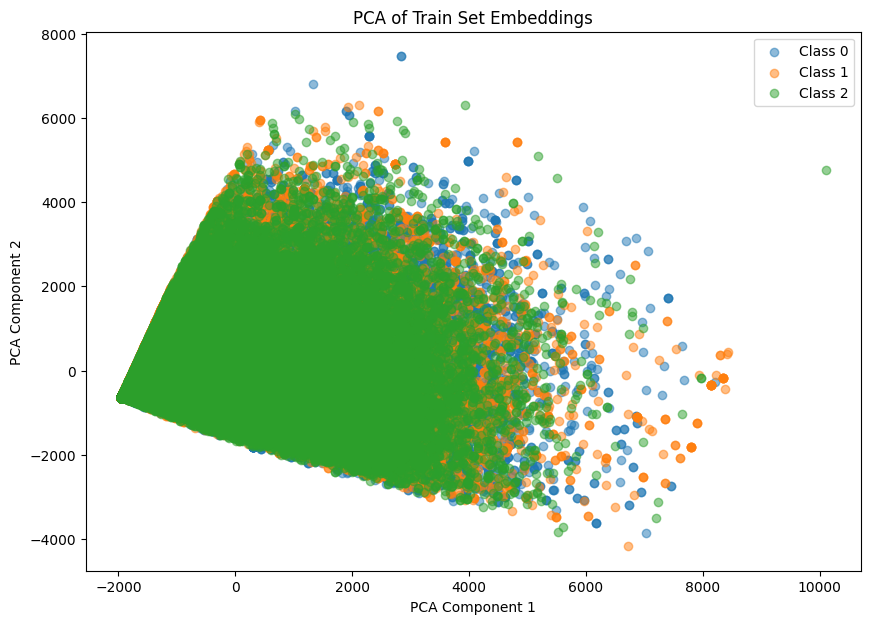

In [ ]:
plt.figure(figsize=(10, 7))
for i in np.unique(y_train):
    idxs = np.where(y_train == i)
    plt.scatter(X_train_pca[idxs, 0], X_train_pca[idxs, 1], label=f'Class {i}', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Train Set Embeddings')
plt.legend()
plt.show()

### **Model Definition**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=30),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### **Model Compile**

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### **Training the model**

In [ ]:
history = model.fit(X_train_pad, y_train, epochs=10, validation_split=0.1, batch_size=32)

Epoch 1/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - accuracy: 0.6400 - loss: 0.7980 - val_accuracy: 0.7348 - val_loss: 0.6140
Epoch 2/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - accuracy: 0.7588 - loss: 0.5926 - val_accuracy: 0.7649 - val_loss: 0.5671
Epoch 3/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - accuracy: 0.7981 - loss: 0.5187 - val_accuracy: 0.7816 - val_loss: 0.5451
Epoch 4/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - accuracy: 0.8291 - loss: 0.4493 - val_accuracy: 0.7925 - val_loss: 0.5386
Epoch 5/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.8556 - loss: 0.3896 - val_accuracy: 0.8031 - val_loss: 0.5342
Epoch 6/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - accuracy: 0.8782 - loss: 0.3310 - val_accuracy: 0.8112 - val_loss: 0.5583
Epoch 7/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.8953 - loss: 0.2884 - val_accuracy: 0.8154 - val_loss: 0.5906
Epoch 8/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.9125 -

### **Evaluate the model**

In [ ]:
def evaluate_model_performance(model, X_test_pad, y_test, history):
    y_test_pred = np.argmax(model.predict(X_test_pad), axis=-1)
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['Negative', 'Neutral', 'Positive']))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

    y_pred = model.predict(X_test_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred_classes)

    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
    y_pred_binarized = label_binarize(y_pred_classes, classes=[0, 1, 2])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
    disp.plot(cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    ax = axes[1]
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(3), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title('ROC AUC for All Classes')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# evaluate_model_performance(model, X_test_pad, y_test, history)

### **Lime** **Interpretebility**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=2fe4bf59d3b273835c47ad78f9e96639506849e1afc2c87b974d54c29b7e8630
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline

In [ ]:
def predict_fn(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=30)
    return model.predict(padded_sequences)

In [ ]:
explainer = lime.lime_text.LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])

In [ ]:
i = 5000
explanation = explainer.explain_instance(X_test[i], predict_fn, num_features=10)

157/157 [==============================] - 1s 8ms/step


In [ ]:
explanation.show_in_notebook(text=True)

In [ ]:
i = 8000
explanation = explainer.explain_instance(X_test[i], predict_fn, num_features=10)

157/157 [==============================] - 2s 9ms/step


In [ ]:
explanation.show_in_notebook(text=True)

### **More Dense Biderectinal LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
dense_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=30),
    Bidirectional(LSTM(256, return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
dense_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
dense_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = dense_model.fit(X_train_pad, y_train, epochs=10, validation_split=0.1, batch_size=32)

Epoch 1/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 137s 25ms/step - accuracy: 0.5960 - loss: 0.8661 - val_accuracy: 0.7203 - val_loss: 0.6421
Epoch 2/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 129s 25ms/step - accuracy: 0.7362 - loss: 0.6371 - val_accuracy: 0.7572 - val_loss: 0.5896
Epoch 3/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 142s 25ms/step - accuracy: 0.7781 - loss: 0.5628 - val_accuracy: 0.7702 - val_loss: 0.5637
Epoch 4/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 142s 25ms/step - accuracy: 0.8089 - loss: 0.5013 - val_accuracy: 0.7815 - val_loss: 0.5555
Epoch 5/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 142s 25ms/step - accuracy: 0.8347 - loss: 0.4467 - val_accuracy: 0.7950 - val_loss: 0.5562
Epoch 6/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 143s 25ms/step - accuracy: 0.8599 - loss: 0.3916 - val_accuracy: 0.8028 - val_loss: 0.5640
Epoch 7/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 141s 25ms/step - accuracy: 0.8799 - loss: 0.3424 - val_accuracy: 0.8113 - val_loss: 0.5710
Epoch 8/10
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 146s 26ms/step - accuracy: 

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.86      0.84     15192
     Neutral       0.81      0.78      0.80     15187
    Positive       0.83      0.83      0.83     15589

    accuracy                           0.82     45968
   macro avg       0.82      0.82      0.82     45968
weighted avg       0.82      0.82      0.82     45968



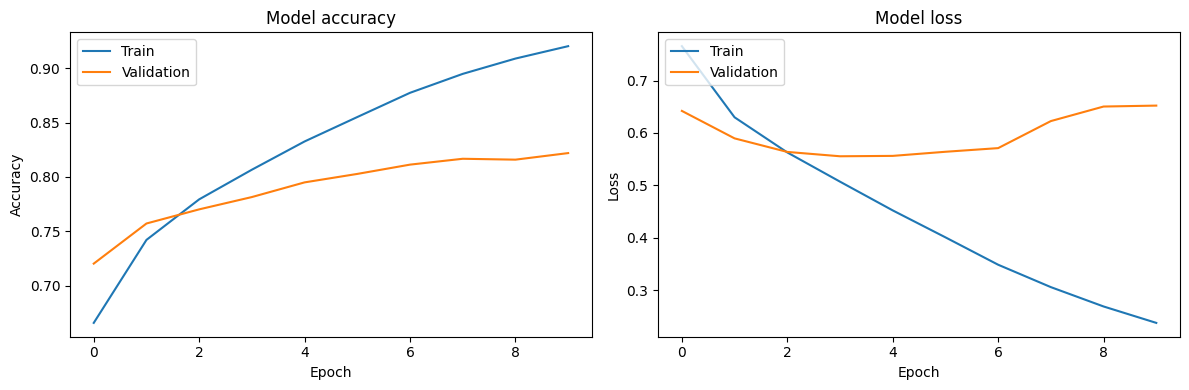

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step


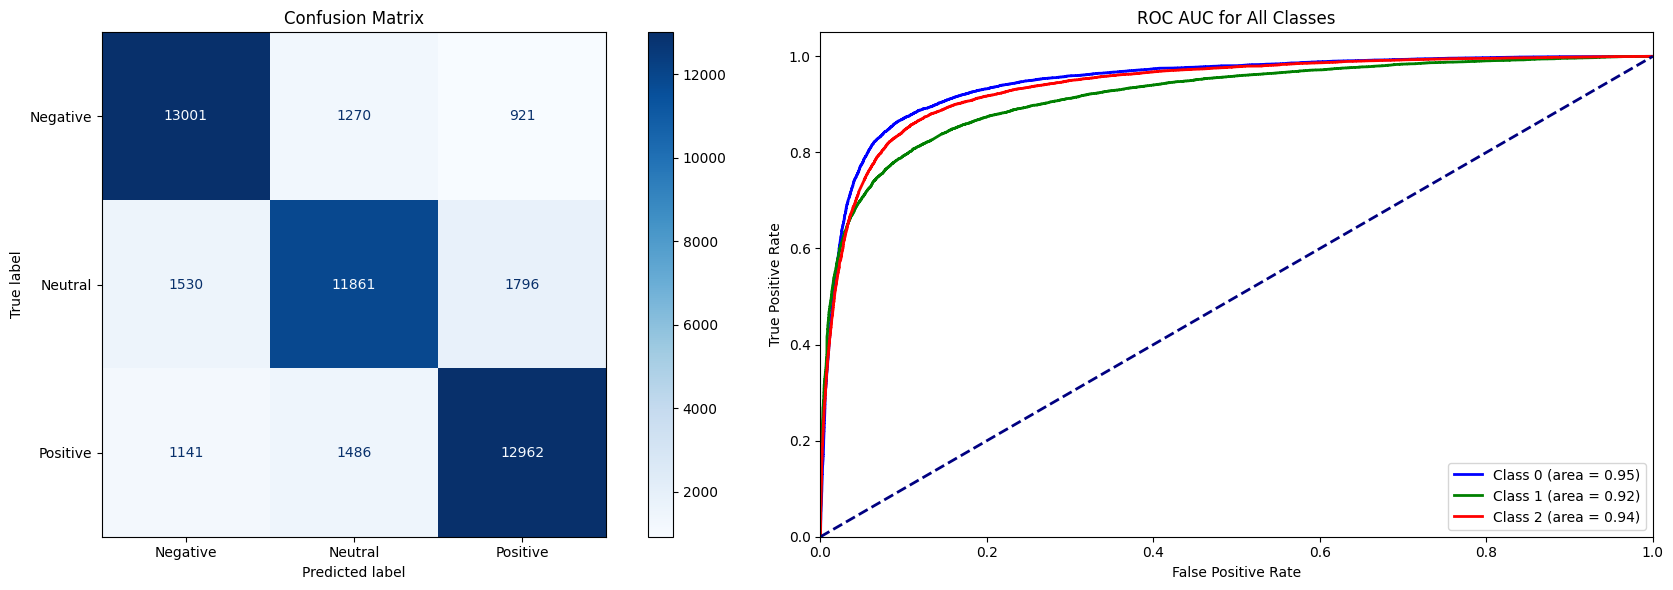

In [ ]:
evaluate_model_performance(dense_model, X_test_pad, y_test, history)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
tune_model = Sequential([
    Embedding(input_dim=20000, output_dim=128),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01))),
    BatchNormalization(),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [ ]:
tune_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = tune_model.fit(X_train_pad, y_train, epochs=20, validation_split=0.1, batch_size=32)

Epoch 1/20
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 164s 29ms/step - accuracy: 0.5877 - loss: 1.7578 - val_accuracy: 0.6304 - val_loss: 0.8617
Epoch 2/20
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 209s 31ms/step - accuracy: 0.7003 - loss: 0.7356 - val_accuracy: 0.6574 - val_loss: 0.7903
Epoch 3/20
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 188s 28ms/step - accuracy: 0.7136 - loss: 0.7018 - val_accuracy: 0.7229 - val_loss: 0.6647
Epoch 4/20
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 200s 28ms/step - accuracy: 0.7253 - loss: 0.6777 - val_accuracy: 0.7376 - val_loss: 0.6353
Epoch 5/20
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 202s 28ms/step - accuracy: 0.7319 - loss: 0.6640 - val_accuracy: 0.7200 - val_loss: 0.6723
Epoch 6/20
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 204s 28ms/step - accuracy: 0.7393 - loss: 0.6505 - val_accuracy: 0.7280 - val_loss: 0.6488
Epoch 7/20
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 202s 29ms/step - accuracy: 0.7440 - loss: 0.6384 - val_accuracy: 0.7206 - val_loss: 0.6815
Epoch 8/20
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 201s 28ms/step - accuracy: 

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.88      0.78     15192
     Neutral       0.81      0.62      0.70     15187
    Positive       0.79      0.79      0.79     15589

    accuracy                           0.76     45968
   macro avg       0.77      0.76      0.76     45968
weighted avg       0.77      0.76      0.76     45968



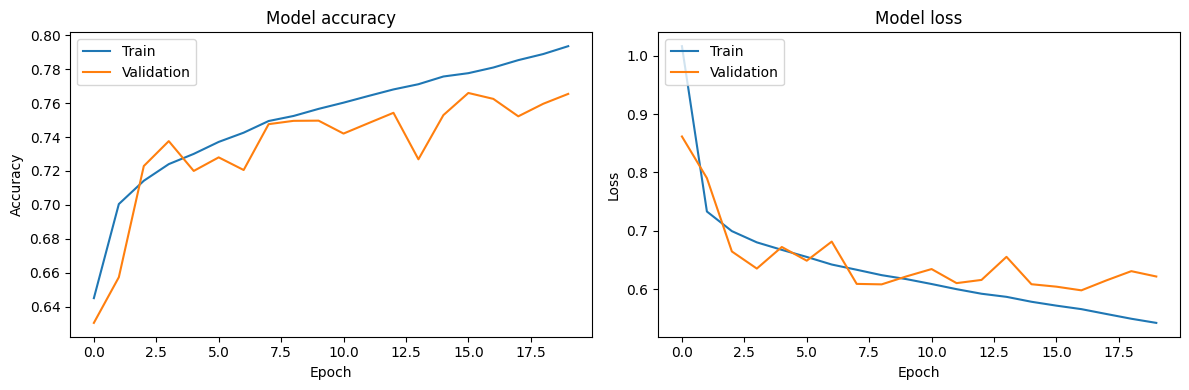

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


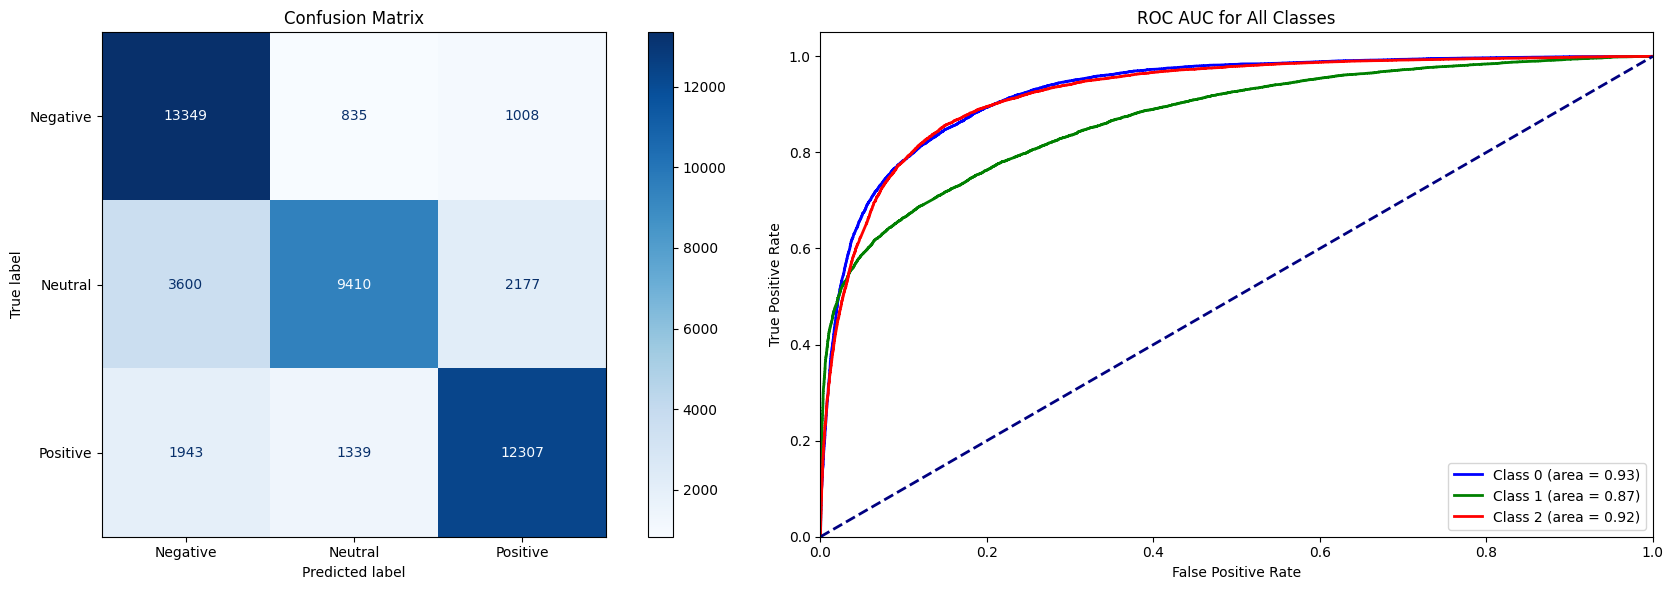

In [ ]:
evaluate_model_performance(tune_model, X_test_pad, y_test, history)

In [ ]:
tune_model.save('sentiment_model_tune.h5')

In [ ]:
from google.colab import files

# Download the model file
files.download('sentiment_model_tune.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Comments**

The Birdirectional LSTM model performs well on the sentiment analysis with the accuracy of 92%, whereas the val_loss is somewhat high which infers there is some overfitting.

**Observations**

The model is more effective with the 'Neutral' class as the recall and f1-score for both of them is highest.

**Summary Table**

**Bidirectional LSTM model using embedding layer**

Train Time - 1356 sec

**Training Data Check**

Confusion Matrix Built - Yes

F1 Score For Positive - 84

F1 Score For Negative - 85

AUC plotted? Yes

AUC = 0.95, 0.92, 0.94 (for classes Negative, Neutral and Positive, respectively)

Accuracy computed? Yes

Accuracy = 82%

Interpretability performed? Yes, local


In [ ]:
dense_model.save('sentiment_analysis_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save the tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    json.dump(tokenizer_json, f)

In [ ]:
pip install flask tensorflow

In [ ]:
!pip install flask_ngrok

In [ ]:
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import emoji

# Function to preprocess text similar to your preprocessing pipeline
def preprocess_text(text):
    def handle_negations(text):
        negation_patterns = ["n't", "not", "never", "no"]
        words = text.split()
        for i in range(len(words)):
            if words[i].lower() in negation_patterns:
                if i + 1 < len(words):
                    words[i + 1] = "NOT_" + words[i + 1]
        return ' '.join(words)

    if isinstance(text, str):
        text = re.sub(r'@\w+', ' ', text)
        text = re.sub(r'#', ' ', text)
        text = re.sub(r'\w+:\/\/\S+', ' ', text)
        text = re.sub(r'\S*@\S*\s?', ' ', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'[^a-zA-Z]+', ' ', text)
        text = handle_negations(text)
        text = emoji.demojize(text)
        text = re.sub(r'\d+', ' ', text)
        text = text.lower()
    return text

# Load the saved Keras model
model = load_model('/content/my_model.h5')

# Function to predict sentiment from text input
def predict_sentiment(text):
    # Preprocess the input text
    text = preprocess_text(text)
    # Tokenize and pad the sequence
    tokenizer = Tokenizer(num_words=5000)  # Assuming you've defined this already
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=30)
    # Make prediction
    prediction = model.predict(padded_sequence)
    return prediction

# Streamlit UI
def main():
    st.title('Sentiment Analysis with Bidirectional LSTM')
    st.markdown('Enter your text to predict sentiment:')

    # User input text area
    user_input = st.text_area('Input Text', '')

    # Predict button
    if st.button('Predict'):
        if user_input.strip() == '':
            st.warning('Please enter some text.')
        else:
            # Predict sentiment
            prediction = predict_sentiment(user_input)
            # Display prediction result
            sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
            predicted_sentiment = sentiment_mapping[np.argmax(prediction)]
            st.success(f'Predicted Sentiment: {predicted_sentiment}')

if __name__ == '__main__':
    main()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

SyntaxError: invalid syntax (<ipython-input-41-31d4c2b8039f>, line 1)